# Non statistical Analysis of the data

## Importation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from DL_Data import DL_Data

## Extraction des données

In [101]:
# Paramètres des données
Station = ['Aigle','Dole','Payerne','Fretaz','Pully','Nyon']
num_sta = 1

Path = "../Database/Precipitations"
df = DL_Data(Path, Station[num_sta])

print('\nDonnées sélectionnées: \n\n\tStation: '+Station[num_sta])

value_column = df.columns[1]
df[value_column] = pd.to_numeric(df[value_column], errors='coerce')

# Gestion des moyennes et maximas par an
n = 1

rows_to_keep = len(df) - (len(df) % n)
df = df.iloc[:rows_to_keep]
df['group'] = np.floor(df.index / n)
df['averaged'] = df.groupby('group')[value_column].mean()*6
df['year'] = df['time'].dt.year
pdmaximas = df.groupby('year')['averaged'].max()


Données sélectionnées: 

	Station: Dole


# Gestion des données en Numpy

In [102]:
years_ = np.array(df['year'].unique())
maximas = np.array(pdmaximas)
values = df['averaged'].dropna().to_numpy()
lv = len(values)
time = np.arange(0,lv,1)
time_in_years = time*n/(6*24*366)+years_[0]

# Moyenne mobile

In [103]:
m = 6

moyenne_mob = np.convolve(values,np.ones(m)/m,mode='same')

### Plot moyenne mobile

(1980.0, 2025.0)

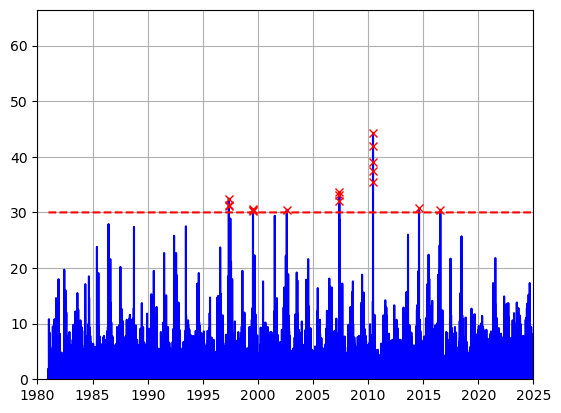

In [104]:
treshold = 30

plt.figure()
plt.plot(time_in_years, moyenne_mob,'b-')
plt.plot(time_in_years,treshold*np.ones(len(time_in_years)),'r--')
plt.plot(time_in_years[moyenne_mob>treshold],moyenne_mob[moyenne_mob>treshold],'rx')
plt.grid('on')
plt.ylim(0,1.5*moyenne_mob.max())
plt.xlim(1980,2025)



# Cumulative

Définitions de la fonction Cumulative avec damping et inertie. Pour obtenir simplement la somme des pluies en fonction du temps il convient de poser damping = inertie = 0

In [105]:
def Cumulative(time_serie, damping, inertia_ratio=0):
    cumul = 0
    cumulative = np.zeros(len(time_serie))
    inertia = 0
    for i,t in enumerate(time_serie):
        if t!=0:
            cumul += t*(1-inertia)
            if inertia >= -1 + inertia_ratio:
                inertia -= inertia_ratio
        elif cumul - damping < 0:
            cumul = 0
        else: 
            cumul -= damping*(1+inertia)
            if inertia <= 1 - inertia_ratio:
                inertia += inertia_ratio
        cumulative[i] = cumul
    return cumulative

### Plot cumulative

(1980.0, 2025.0)

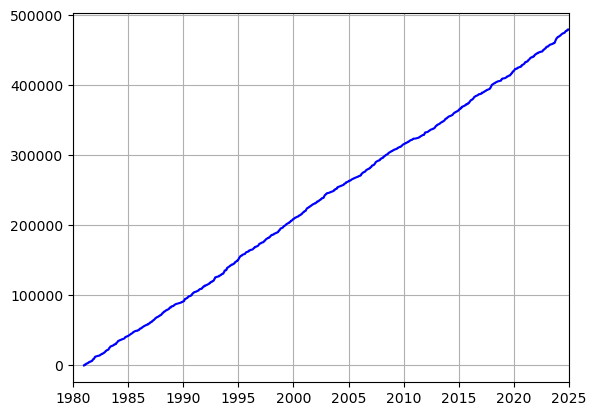

In [106]:
cumulative = Cumulative(values,damping=0.0,inertia_ratio=0.0)

plt.figure()
plt.plot(time_in_years, cumulative, 'b')
plt.grid('on')
plt.xlim(1980,2025)

## Cumulative par année

Ici les données sont retraitées pour obtenir la cumulative par année. slope_interval donne l'écart sur lequel la pente est calculée et m controle la largeur de la fenetre pour faire une moyenne mobile sur ces pentes

In [107]:
years = sorted(df['year'].unique())
rain_per_year = [df.loc[df['year'] == y, value_column].values for y in years]
maxlenyear = max(len(r) for r in rain_per_year)

rain_matrix = np.zeros(shape=[len(years), maxlenyear])
Cumulatives = np.zeros(shape=[len(years), maxlenyear])
Cumulative_slopes = np.zeros(shape=[len(years), maxlenyear])
Cumulative_slopes_conv = np.zeros(shape=[len(years), maxlenyear])

slope_interval = 6*24*7
m = 6*24*21

for i, r in enumerate(rain_per_year):
    rain_matrix[i, :len(r)] = r
    Cumulatives[i, :len(r)] = Cumulative(rain_matrix[i, :len(r)], damping=0.0, inertia_ratio=0.0)
    for j, k in enumerate(Cumulatives[i, :(len(r)-slope_interval)]):
        Cumulative_slopes[i, j] = (Cumulatives[i, j+slope_interval] - Cumulatives[i,j])/slope_interval
    Cumulative_slopes_conv[i] = np.convolve(Cumulative_slopes[i], np.ones(m)/m, mode='same')

# Plot des cumulative
year contrôle l'année qui est plot

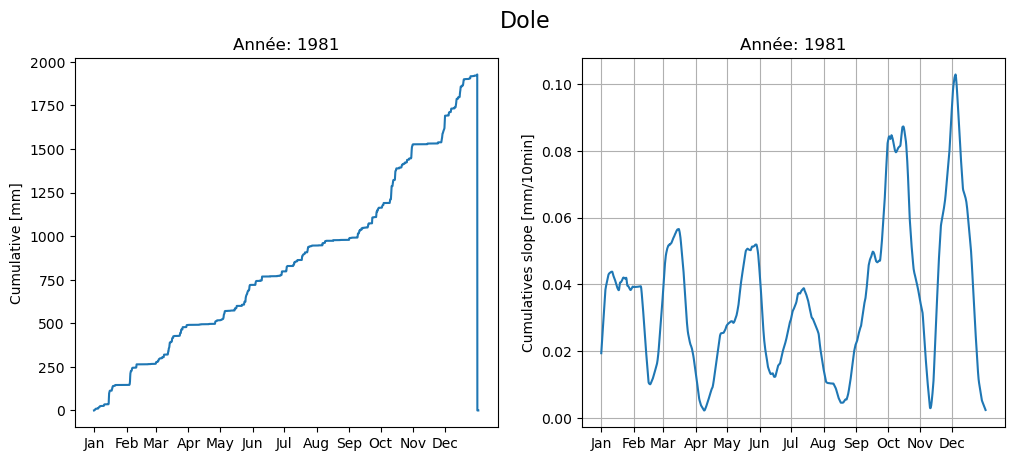

In [108]:
year = 0

month_starts = np.cumsum([0] + [calendar.monthrange(years[0]+year, m)[1] for m in range(1, 12)])
month_labels = [calendar.month_abbr[m] for m in range(1, 13)]

figs, axs = plt.subplots(1,2)
figs.set_figwidth(12)

axs[0].plot(np.arange(maxlenyear)/(6*24), Cumulatives[year])
axs[0].set_xticks(month_starts)
axs[0].set_xticklabels(month_labels)
axs[0].set_ylabel('Cumulative [mm]')

axs[1].plot(np.arange(maxlenyear)/(6*24), Cumulative_slopes_conv[year])
axs[1].set_xticks(month_starts)
axs[1].set_xticklabels(month_labels)
axs[1].set_ylabel('Cumulatives slope [mm/10min]')

axs[0].set_title(f'Année: {year+years[0]}')
axs[1].set_title(f'Année: {year+years[0]}')
plt.suptitle(Station[num_sta], fontsize=16)
plt.grid('on')



Plot d'une heatmap des cumulatives par an au cours de l'années

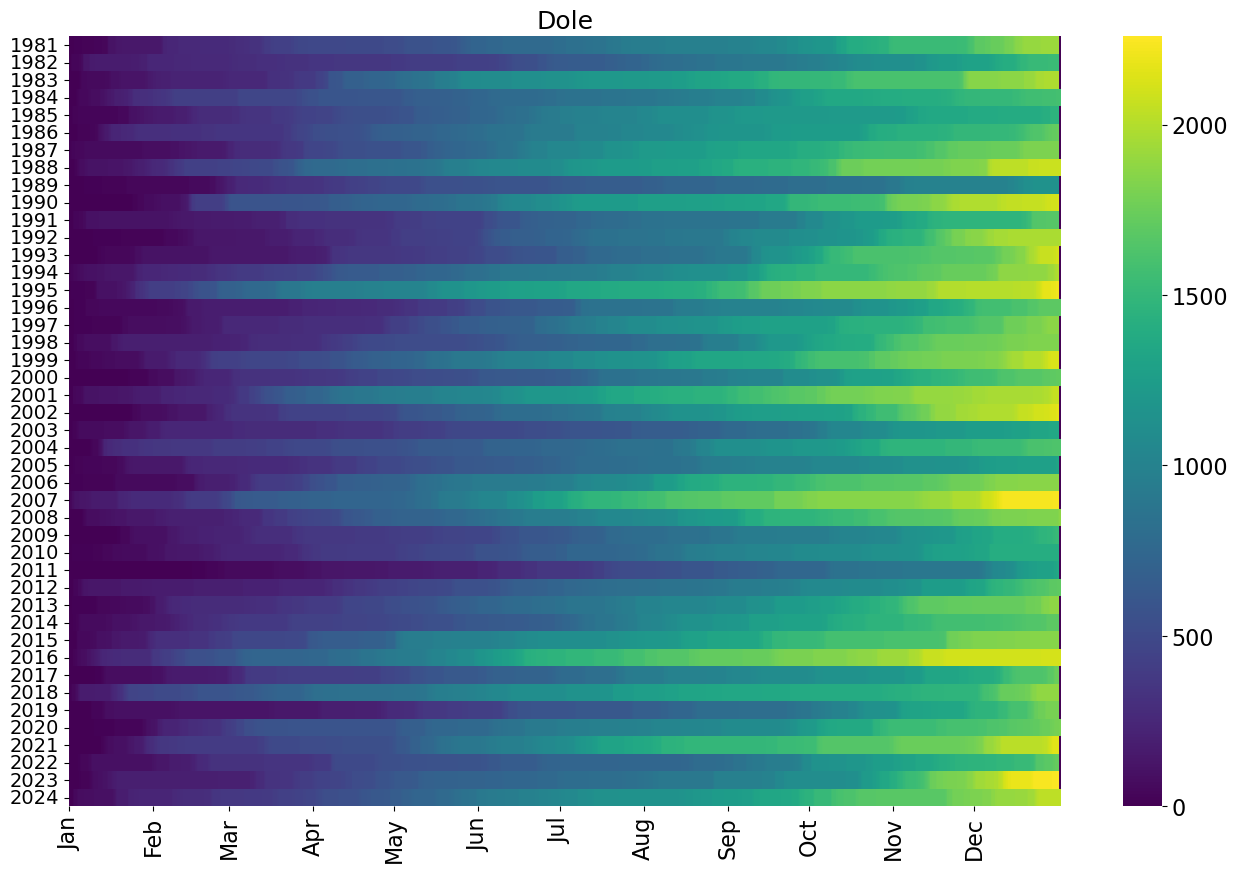

In [109]:
month_starts = np.cumsum([0] + [6*24*calendar.monthrange(years[0]+year, m)[1] for m in range(1, 12)])

plt.figure(figsize=(16,10))
ax = sns.heatmap(Cumulatives, yticklabels=years[0]+np.arange(0,len(years)), cmap = 'viridis')
ax.set_xticks(month_starts)
ax.set_xticklabels(month_labels, fontsize = 16)
ax.set_yticklabels(years[0]+np.arange(0,len(years)), fontsize=14)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16) 
plt.title(Station[num_sta], fontsize=18)
plt.show()

Valeur finale des cumulatives par années

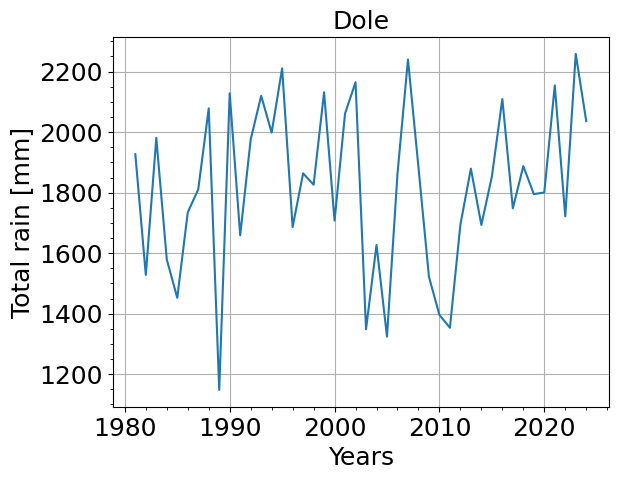

In [110]:
max_cumulatives = np.max(Cumulatives, axis=1)
plt.plot(years, max_cumulatives)
plt.grid(True)
plt.xlabel('Years', fontsize=18)
plt.ylabel('Total rain [mm]', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(Station[num_sta], fontsize=18)
plt.minorticks_on()

Transformation de fourier sur le signal de la valeur finale des cumulatives pour détecter une fréquence importante

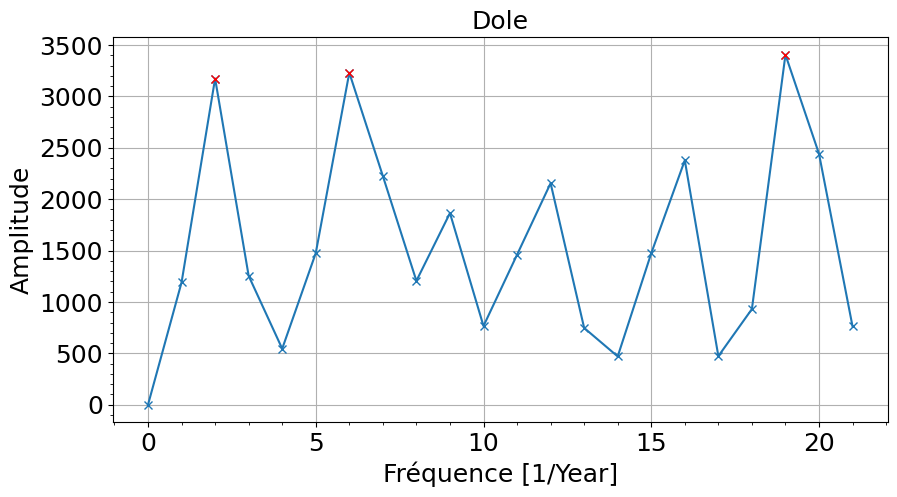

In [111]:
# Calcul de la FFT
max_cumulatives = max_cumulatives - np.mean(max_cumulatives)
fft_vals = np.fft.fft(max_cumulatives)
fft_freqs = np.fft.fftfreq(len(max_cumulatives), 1/len(years))

# On prend seulement la partie positive
half_n = len(max_cumulatives) // 2
fft_vals = np.abs(fft_vals[:half_n])
fft_freqs = fft_freqs[:half_n]

fs=18
plt.figure(figsize=(10, 5))
plt.plot(fft_freqs, fft_vals, 'x-')
plt.plot(fft_freqs[fft_vals>np.max(fft_vals*0.75)], fft_vals[fft_vals>np.max(fft_vals*0.75)], 'xr')
plt.title("Spectre de fréquence")
plt.xlabel("Fréquence [1/Year]", fontsize=18)
plt.ylabel("Amplitude", fontsize=18)
plt.title(Station[num_sta], fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.minorticks_on()
plt.grid(True)
plt.show()

In [112]:
cross_station = pd.read_csv("AllFFT.csv")
cross_station[Station[num_sta]] = fft_vals
pd.DataFrame.to_csv(cross_station, "AllFFT.csv", index=False)

# FFT par tranche d'années

Pour repérer si il y a une évolution dans les fréquences au cours des années, les données sont séparées par tranches d'années et la FFT est refaite. width_mobile contrôle la largeur des tranches d'années.

In [113]:
width_mobile = 30
num_mobile = np.max(years)-np.min(years)-width_mobile
num_max_values = 3

ffts_vals = np.zeros(shape=[num_mobile, width_mobile//2])
ffts_freqs = np.zeros(shape=[num_mobile, width_mobile//2])
amplitudes_max = np.zeros(shape=[num_mobile, num_max_values])
frequencies_max = np.zeros(shape=[num_mobile, num_max_values])

for i in range(num_mobile):
    signal_mobile = max_cumulatives[i:i+width_mobile]
    signal_mobile = (signal_mobile-np.mean(signal_mobile))/np.std(signal_mobile)
    fft_temp_val = np.fft.fft(signal_mobile)
    fft_temp_freq = np.fft.fftfreq(len(signal_mobile), 1/len(years))
    half_n = len(signal_mobile) // 2
    ffts_vals[i] = np.abs(fft_temp_val[:half_n])
    ffts_freqs[i] = fft_temp_freq[:half_n]
    max_vals_index = np.argsort(ffts_vals[i])[-num_max_values:][::-1]
    amplitudes_max[i] = ffts_vals[i][max_vals_index]
    frequencies_max[i] = ffts_freqs[i][max_vals_index]

Heat map des frquences importante par tranche d'années. La fréquence nulle a été posée égale a zéro car elle est très importante, et cela permet d'améliorer la résolution du graphique.

[]

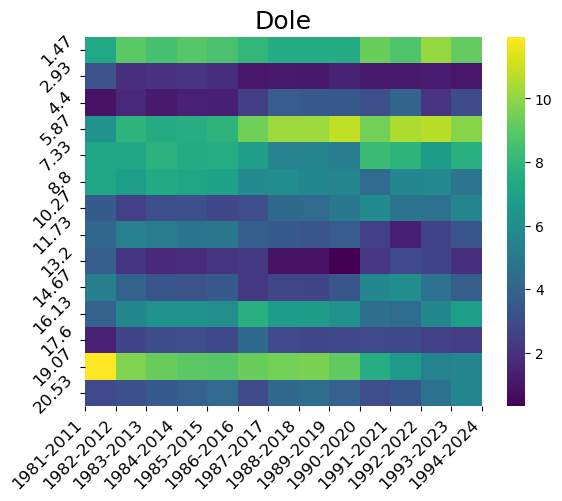

In [114]:
x_labels = [f"{np.min(years)+i}-{np.min(years)+i+width_mobile}" for i in range(len(years)-width_mobile)]

ax = sns.heatmap(ffts_vals[:,1:].transpose(), cmap='viridis')
ax.set_yticklabels(np.round(ffts_freqs[0,1:],2), rotation=45, fontsize=12)
ax.set_xticks(np.arange(num_mobile+1))
ax.set_xticklabels(x_labels, rotation=45, fontsize=12, ha='right')
plt.title(Station[num_sta], fontsize=18)
ax.plot()

For an analysis of all station I created the file AllFFT.csv that compile the signal in the frequency space for each station.

In [56]:
All_stations = pd.read_csv("AllFFT.csv")

All_stations['product'] = All_stations[Station[:]].prod(axis=1)
All_stations['average'] = All_stations[Station[:]].mean(axis=1)

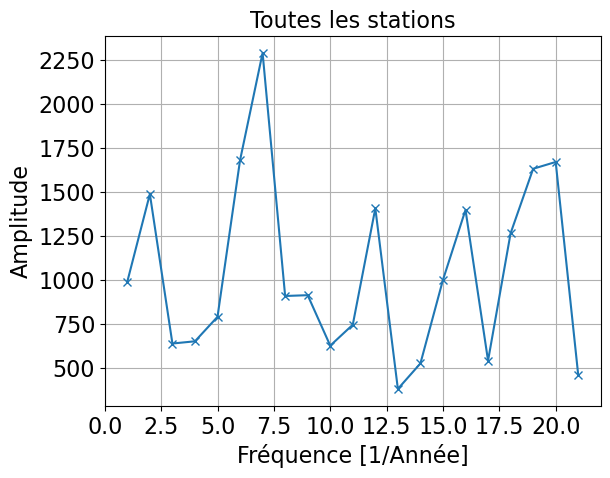

In [40]:
fs=16
plt.figure()
plt.plot(All_stations['freq'][1:], All_stations['average'][1:],'-x')
plt.grid('on')
plt.yscale('linear')
plt.xlabel("Fréquence [1/Année]", fontsize=fs)
plt.ylabel("Amplitude", fontsize=fs)
plt.title('Toutes les stations', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.show()